In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [6]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/top40_cell_cycle.csv")

# Define features and target
X = df.drop(columns=['phase', 'age'])  # Features
y = df['age']  # Target: age

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=949
)

In [3]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=600,
    eta = 0.1,
    gamma = 0,
    max_depth=5,
    random_state=949
)

In [4]:
## hypertuning

param_grid = {
    'n_estimators': [500],
    'max_depth': [2,3,5,10],
    'eta': [0.025, 0.05, 1]          
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator= xgb_model,
    param_grid=param_grid,
    cv=10,
    scoring= 'neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)
#print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'eta': 0.05, 'max_depth': 5, 'n_estimators': 500}


In [7]:
# retrain model

xgb_model = XGBRegressor(
    n_estimators=500,
    eta = 0.05,
    gamma = 0,
    max_depth=5,
    random_state=949
)

xgb_model.fit(X_train, y_train)

# Predict
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [8]:
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)

=== Training Set ===
RMSE: 0.4755

=== Test Set ===
RMSE: 1.3727
RMSE per phase (Train):
phase
G0    0.400079
G1    0.415880
G2    0.554142
M     0.437833
S     0.550130
dtype: float64

RMSE per phase (Test):
phase
G0    1.511565
G1    1.134281
G2    1.418198
M     3.297515
S     1.451516
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_13080/3800106582.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_13080/3800106582.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(


In [10]:
# === Load existing results DataFrame ===
results_df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv", index_col=0)

# === Set values ===
model_name = "XGBoost (top 40)"  # or whatever is appropriate
results_df.loc[model_name, 'Overall'] = rmse_test

# Fill in per-phase RMSEs
for phase in ['G0', 'G1', 'G2', 'S']:
    if phase in rmse_per_phase_test.index:
        results_df.loc[model_name, phase] = rmse_per_phase_test[phase]

# === Save updated results ===
results_df.to_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv")

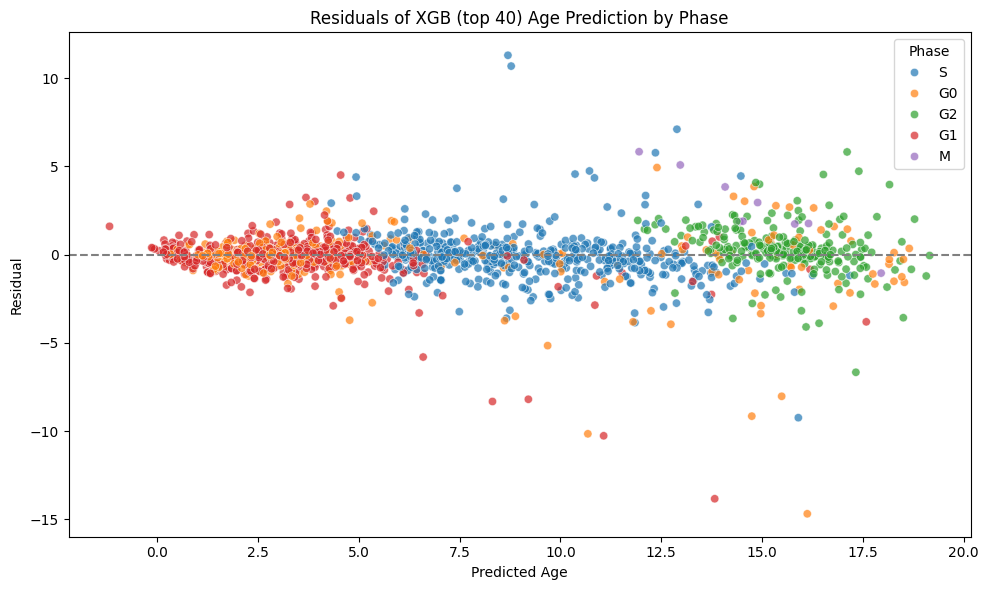

In [7]:
## PLOT RESIDUALS
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'True Age': y_test,
    'Predicted Age': y_test_pred,
    'Residual': y_test - y_test_pred,
    'Phase': df.loc[y_test.index, 'phase']
})

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Predicted Age',
    y='Residual',
    hue='Phase',
    palette='tab10',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of XGB (top 40) Age Prediction by Phase")
plt.xlabel("Predicted Age")
plt.ylabel("Residual")
plt.legend(title='Phase')
plt.tight_layout()

# Save the plot
plot_path = "xgb_regression_top40.png"
plt.savefig(plot_path, dpi=300)
plt.show()

                     Normalized Weight
Feature                               
E2F1..nuc.median.             0.076788
cycA..nuc.median.             0.056419
cycD1..nuc.median.            0.041251
Int_Intg_DNA_nuc              0.038028
Cdh1..nuc.median.             0.037588
Nuc.area                      0.036635
cycE..nuc.median.             0.036196
Cdt1..nuc.median.             0.036049
p21..nuc.median.              0.035610
Skp2..nuc.median.             0.033045
PCNA..nuc.median.             0.032019
cycD1..cyto.median.           0.028722
CDK2..cyto.median.            0.028136
RB..nuc.median.               0.027843
CDK4..nuc.median.             0.026304
pH2AX..nuc.median.            0.025425
cMyc..nuc.median.             0.024326
p27..nuc.median.              0.024106
ERK..nuc.median.              0.023007
Skp2..cell.median.            0.022860
cycB1..nuc.median.            0.021908
S6..nuc.median.               0.021835
CDK2..nuc.median.             0.021835
cFos..nuc.median.        

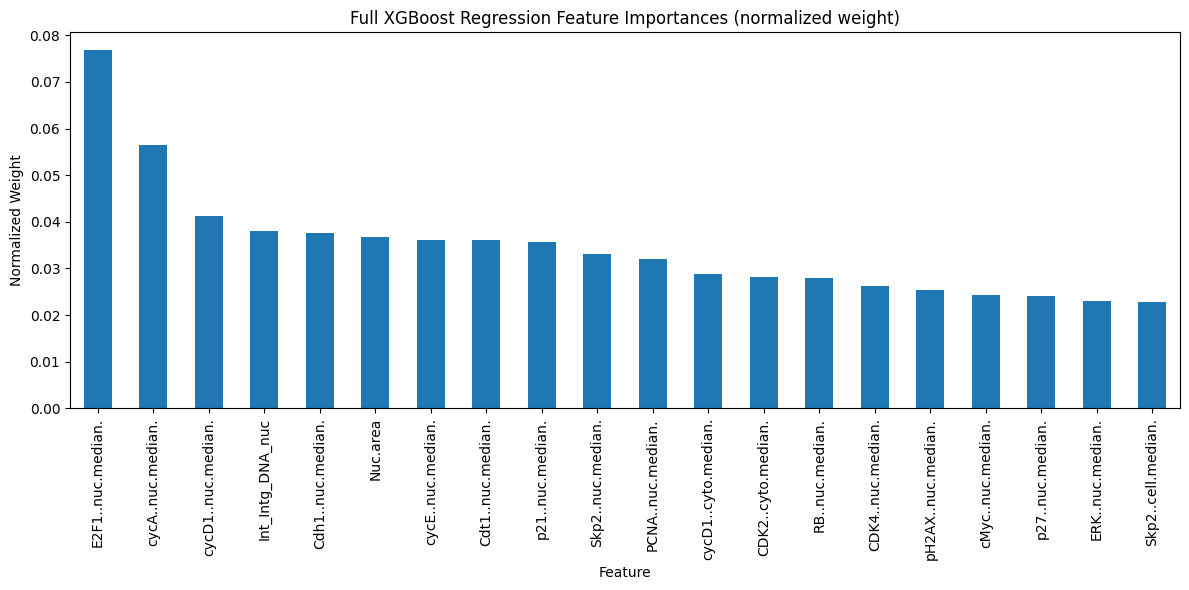

In [4]:
# MDI feature ranking (weight)
booster = xgb_model.get_booster()

# Get importance by "weight" (~ MDI)
importance_dict = booster.get_score(importance_type='weight')

# Normalize to sum to 1
total = sum(importance_dict.values())
normalized_scores = {k: v / total for k, v in importance_dict.items()}


importance_df = pd.DataFrame.from_dict(normalized_scores, orient='index', columns=['Normalized Weight'])
importance_df.index.name = 'Feature'
importance_df = importance_df.sort_values(by='Normalized Weight', ascending=False)
print(importance_df)

# Select top n for plotting
top_n = 20
top_features_df = importance_df.head(top_n)

# Plot
top_features_df.plot(kind='bar', figsize=(12, 6), legend=False)
plt.title(f"Full XGBoost Regression Feature Importances (normalized weight)")
plt.ylabel("Normalized Weight")
plt.xlabel("Feature")
plt.tight_layout()
# Save the plot
plot_path = "xgb_regression_importance_top40.png"
plt.savefig(plot_path, dpi=300)
plt.show()